# Wannierisation (including SAWF)

This tutorial shows how to construct (Symmetry adapted) Wannier functions with WannierBerri, with magnetic symmetries. We will use the example of bcc Fe.

## 0. Compute QuantumEspresso files

in tthe tutorial repository only the input files for Quantum ESPRESSO are provided
to obtain the necessary files one needs to run
```
pw.x < Fe_pw_scf_in > Fe_pw_scf_out
pw.x < Fe_pw_nscf_in > Fe_pw_nscf_out
wannier90.x -pp Fe
pw2wannier90.x < Fe_pw2wan_in > Fe_pw2wan_out
```
 
## 1. Setup

First import modules and set up the parallel environment



In [1]:
import ray
# Initialize Ray with 8 CPU cores
# Do this only once at the beginning of your script. Initializing multiple times will lead to errors.
ray.init(num_cpus=8)
# If needed, you can do ray.shutdown() at the end of your script to clean up resources.

/home/stepan/github/WannierBerri-tutorial/.conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-22 02:08:13,575	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2026-02-22 02:08:15,258	INFO worker.py:1918 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.12.12
Ray version:,2.48.0
Dashboard:,http://127.0.0.1:8265


In [2]:

import os

from matplotlib import pyplot as plt
import scipy
import wannierberri as wb
import numpy as np

path_data = "./pwscf/"  # adjust path if needed to point to the data in the tests fo wannier-berri repository

assert os.path.exists(path_data), f"Path {path_data} does not exist"

import irrep, spglib

print (f"using wannier-berri version: {wb.__version__}")
print (f"using irrep version: {irrep.__version__}")
print (f"using spglib version: {spglib.__version__}")

using wannier-berri version: 1.8.0
using irrep version: 2.6.0
using spglib version: 2.6.0


## 1. Read the bandstructure from Quantum ESPRESSO

we use the Bnadstructure object form irrep to read the bandstructure from Quantum ESPRESSO. It also can be used to read from VASP, ABINIT, GPAW etc. , see documentation of irrep for more details.

In [15]:

from irrep.bandstructure import BandStructure
assert os.path.exists(path_data), f"Path {path_data} does not exist"
bandstructure = BandStructure(code='espresso',   # to work with VASP or abinit please refer to the documentation of irrep
                            prefix=os.path.join(path_data, "Fe"),
                            magmom=[[0,0,1]],  # set the magnetic moments for a magnetic system (units do not matter)
                            include_TR=True)  # set include_TR=False if you do not want to include the symmetries involving time reversal (magnetic symmetries)
spacegroup = bandstructure.spacegroup
# spacegroup.show() # uncomment to see the detected symmetries of the system

## 2. Create the "w90files"

Here we use the Wannier90data object, to create the eig, symmetrizer, and mmn file (see below)


In [16]:
w90data = wb.w90files.Wannier90data.from_bandstructure(
    bandstructure=bandstructure,
    files = ["eig","symmetrizer", "mmn"]  # remove "mmn" if you do the next step (see below) 
)


got irreducible=None, mp_grid=None, seedname=wannier90, files=['eig', 'symmetrizer', 'mmn'],  projections=None, unk_grid=None, normalize=True
mpgrid = [4 4 4], 64
detected grid=(np.int64(4), np.int64(4), np.int64(4)), selected_kpoints=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
self.irreducible=False
mpgrid = [4 4 4], 64
Shells found with weights [0.41728408] and tolerance 7.693398823301265e-16
NK= 64, selected_kpoints = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63], kptirr = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


## 3. Read the mmn file from pw2wannier90 (if needed)

irrep only reads the plane wave coefficients of the wavefunctions, and not the projections (EXCEPT for GPAW). This is totally fine for the symmetrizer, and ok for the amn file, but is very inaccurate for the mmn file. 

This step is necessary if :

* QE/VAST/Abinit with ultrasoft or PAW pseudopotentials.

Not needed if:
* GPAW (projections are read by irrep)
* QE/VAST/Abinit with norm-conserving pseudopotentials (plane wave coefficients are sufficient to construct the mmn file in this case)

In [19]:
mmn = wb.w90files.mmn.MMN.from_w90_file(os.path.join(path_data,"Fe"), bkvec=w90data.bkvec)
w90data.set_file("mmn", mmn, overwrite=True)

### 3.1 Save the w90files with to npz for later use (optional)
You can save the created w90files to npz format for later use, to save time. Later thay can be loaded

In [20]:
w90data.to_npz(os.path.join(path_data,"Fe_w90data"))
w90data_loaded = wb.w90files.Wannier90data.from_npz(os.path.join(path_data,"Fe_w90data"))

saving to ./pwscf/Fe_w90data.sawf.npz : 
saving to ./pwscf/Fe_w90data.bkvec.npz : 
saving to ./pwscf/Fe_w90data.chk.npz : 
saving to ./pwscf/Fe_w90data.eig.npz : 
saving to ./pwscf/Fe_w90data.mmn.npz : 
files = ['mmn', 'eig', 'amn', 'bkvec']
Trying to read file mmn from npz ./pwscf/Fe_w90data.mmn.npz
setting file mmn from npz ./pwscf/Fe_w90data.mmn.npz as <wannierberri.w90files.mmn.MMN object at 0x73fd9bd57d10>
Trying to read file eig from npz ./pwscf/Fe_w90data.eig.npz
setting file eig from npz ./pwscf/Fe_w90data.eig.npz as <wannierberri.w90files.eig.EIG object at 0x73fff96cdcd0>
Trying to read file amn from npz ./pwscf/Fe_w90data.amn.npz
Trying to read file bkvec from npz ./pwscf/Fe_w90data.bkvec.npz
setting file bkvec from npz ./pwscf/Fe_w90data.bkvec.npz as <wannierberri.w90files.bkvectors.BKVectors object at 0x73fff96ce390>


## 3 Choose projections

This is similar to wannier90. However, in this case the projections already include the symmetry information. 

'position_num' may contain only one position of the ornit, in this case the others will be generated by symmetry. However, this should be used with caution, as the generated positions may differ by a lattice vector, which may cause problems in some cases.

In [21]:

from wannierberri.symmetry.projections import Projection, ProjectionsSet
# now set the transformations of WFs. Make sure, the projections are consistent with the amn file
proj_s = Projection(position_num = [[0,0,0]], orbital='s', spacegroup=spacegroup)
proj_p = Projection(position_num = [[0,0,0]], orbital='p', spacegroup=spacegroup)
proj_d = Projection(position_num = [[0,0,0]], orbital='d', spacegroup=spacegroup)
projections_set = ProjectionsSet(projections=[proj_s, proj_p, proj_d])


## 4 set the amn and symmetry of future Wannier functions

The following line serves two purposes: 
1. creates and sets the amn file - initial guess for the Wannier functions
2. sets how the Wannier functions should transform under the symmetry operations.

Bothe are based on the `projections_set`


In [22]:
w90data.set_projections(projections_set, bandstructure=bandstructure)

finding num points from 3 projections
Creating amn. Using projections_set 
ProjectionsSet with 9 Wannier functions and 0 free variables
Projection 0, 0, 0:['s'] with 1 Wannier functions on 1 points (1 per site)
Projection 0, 0, 0:['p'] with 3 Wannier functions on 1 points (3 per site)
Projection 0, 0, 0:['d'] with 5 Wannier functions on 1 points (5 per site)


## 7. Wannierise

Note, that in wannierberri there is not separation into "disentangle" and "wannierise" steps, as in wannier90. Both procedures are done together at every iteration. If you want to do only disentanglement, you can set `localise=False`. then `num_iter` will mean the number of disentanglement iterations.

In [ ]:
froz_max=25
_ = wb.wannierise.wannierise( 
                w90data=w90data,
                froz_min=4,
                froz_max=froz_max,
                outer_min=0,
                outer_max=100,
                print_progress_every=20,
                num_iter=100,
                conv_tol=1e-6,
                localise=True,
                sitesym=True,
                )

####################################################################################################
starting WFs
----------------------------------------------------------------------------------------------------
wannier centers and spreads
----------------------------------------------------------------------------------------------------
  0.000000000000    0.000000000000    0.000000000000   |    18.588454328787
  0.000000000000    0.000000000000    0.000000000000   |    18.899022837914
  0.000000000000    0.000000000000    0.000000000000   |    21.497047041809
  0.000000000000    0.000000000000    0.000000000000   |    22.959220386191
  0.000000000000    0.000000000000    0.000000000000   |    23.483954050091
  0.000000000000    0.000000000000    0.000000000000   |    19.719608624370
  0.000000000000    0.000000000000    0.000000000000   |    23.483954050091
  0.000000000000    0.000000000000    0.000000000000   |    19.719608624370
  0.000000000000    0.000000000000    0.00000000

## 9. Create System_w90 object

In [39]:

system = wb.system.System_w90(w90data= w90data, berry=True, transl_inv_JM=True,
                                  symmetrize=True)

# optionally - save it for later use
system.save_npz("Fe_system")

irreducible : False, symmetrize set to True
setting Rvec
kpt_red=array([[0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.25],
       [0.  , 0.  , 0.5 ],
       [0.  , 0.  , 0.75],
       [0.  , 0.25, 0.  ],
       [0.  , 0.25, 0.25],
       [0.  , 0.25, 0.5 ],
       [0.  , 0.25, 0.75],
       [0.  , 0.5 , 0.  ],
       [0.  , 0.5 , 0.25],
       [0.  , 0.5 , 0.5 ],
       [0.  , 0.5 , 0.75],
       [0.  , 0.75, 0.  ],
       [0.  , 0.75, 0.25],
       [0.  , 0.75, 0.5 ],
       [0.  , 0.75, 0.75],
       [0.25, 0.  , 0.  ],
       [0.25, 0.  , 0.25],
       [0.25, 0.  , 0.5 ],
       [0.25, 0.  , 0.75],
       [0.25, 0.25, 0.  ],
       [0.25, 0.25, 0.25],
       [0.25, 0.25, 0.5 ],
       [0.25, 0.25, 0.75],
       [0.25, 0.5 , 0.  ],
       [0.25, 0.5 , 0.25],
       [0.25, 0.5 , 0.5 ],
       [0.25, 0.5 , 0.75],
       [0.25, 0.75, 0.  ],
       [0.25, 0.75, 0.25],
       [0.25, 0.75, 0.5 ],
       [0.25, 0.75, 0.75],
       [0.5 , 0.  , 0.  ],
       [0.5 , 0.  , 0.25],
       [0.5 , 0. 

## 8. Bands along path

### 8.1 calculate bands

In [40]:
# all kpoints given in reduced coordinates
path=wb.Path.from_nodes(system,
                nodes=[
                    [0.0000, 0.0000, 0.0000 ],   #  G
                    [0.500 ,-0.5000, -0.5000],   #  H
                    [0.7500, 0.2500, -0.2500],   #  P
                    [0.5000, 0.0000, -0.5000],   #  N
                    [0.0000, 0.0000, 0.000  ]
                        ] , #  G
                labels=["G","H","P","N","G"],
                length=200 )   # length [ Ang] ~= 2*pi/dk

bands_path=wb.evaluate_k_path(system, path=path)



Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x740000d52240>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x73fff9525070> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x740000d52240>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 215 points and labels {0: 'G', 70: 'H', 130: 'P', 165: 'N', 214: 'G'}
generating K_list
Done 
Done, sum of weights:215.0

###################

/home/stepan/github/wannier-berri/wannierberri/grid/path.py:272: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


### 8.2 plot bands

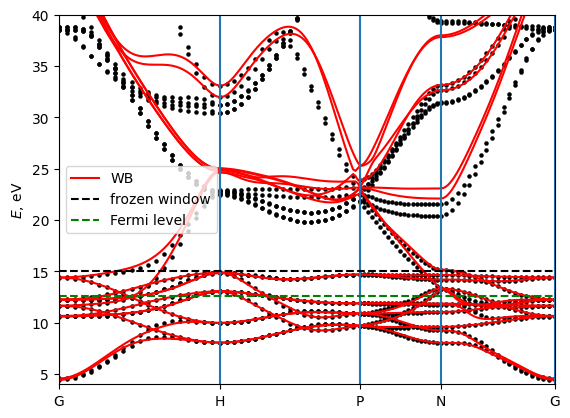

In [41]:

# plot the bands and compare with pw
# EF = 12

A = np.loadtxt("./pwscf/Fe_bands_pw.dat")
bohr_ang = scipy.constants.physical_constants['Bohr radius'][0] / 1e-10
alatt = 5.4235* bohr_ang
A[:,0]*= 2*np.pi/alatt
A[:,1] = A[:,1] 
plt.scatter(A[:,0], A[:,1], c="black", s=5)

    

bands_path.plot_path_fat(path,
                quantity=None,
                # save_file="Fe_bands.pdf",
                Eshift=0,
                Emin=-10, Emax=50,
                iband=None,
                mode="fatband",
                fatfactor=20,
                cut_k=False,
                linecolor="red",
                close_fig=False,
                show_fig=False,
                label=f"WB"
                )

plt.ylim(4, 40)
plt.hlines(froz_max, 0, A[-1,0], linestyles="dashed", label="frozen window", color="black")
plt.hlines(12.6, 0, A[-1,0], linestyles="dashed", label="Fermi level", color="green")
plt.legend()
plt.savefig("Fe_bands.pdf")


## 9. AHC and Ohmic conductivity

### 9.1 calculate 

In [ ]:
results_grid = {}
efermi = np.linspace(12.4,12.8,1001)
param = dict(Efermi=efermi)
calculators_grid = {
     "CDOS": wb.calculators.static.CumDOS(**param),
                "ohmic": wb.calculators.static.Ohmic_FermiSea(**param),
                "ahc_internal": wb.calculators.static.AHC(kwargs_formula={"external_terms":False}, **param),
            "ahc_external": wb.calculators.static.AHC(kwargs_formula={"internal_terms":False}, **param ),	
}

grid =  wb.Grid(system, NKFFT=6, NK=48)

result_grid = wb.run(system, 
                     grid, 
                     calculators_grid, 
                    fout_name="Fe_grid",
                    adpt_num_iter=0,
                    symmetrize=False,  # we do not symmetrize here so that we can chaeck how symmetric are the WFs
                    use_irred_kpt=False,
                    print_progress_step=1,
                    print_Kpoints=False,
                    )


# plot the bands to compare with pw





### 5.2 Plot 

In [ ]:
def plotxyz(axes, x, data, pre = "", label="",ls="-"):
    for i in range(3):
        ax =axes[i]
        ax.plot(x, data[:,i], ls, label=label)
        ax.set_title(f"{pre}{'xyz'[i]}")



quantities =  ["ahc_internal", "ahc_external","ohmic"]
    
nfig = len(quantities)
for quantity in quantities:
    fig = None
    res = result_grid.results[quantity]
    data = res.data
    E = res.Energies[0]
    if fig is None:
        if data.ndim == 2:
            nfigx = 1
            nfigy = data.shape[1]
        elif data.ndim == 3:
            nfigx = data.shape[1]
            nfigy = data.shape[2]
        fig, axes = plt.subplots(nfigx, nfigy, figsize=(5*nfigy,5*nfigx))
    if nfigx ==1:
        plotxyz(axes, E, data)
    else:
        for i in range(nfigx):
            plotxyz(axes[i], E, data[:,i], pre="xyz"[i], )
    for ax in axes.flat:
        ax.legend()
    fig.suptitle(quantity)
    plt.show()
    plt.close()
    
        
